In [1]:
from math import pi
import itertools as itt
from collections import defaultdict

import numpy as np

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from webcolors import hex_to_rgb
from IPython.display import Image
from src.root_path import root_path

from src.data.rasters import load_site_formated_raster
from src.metrics.consolidated_tstat import tstat_cluster_mass
from src.metrics.significance import _significance

from src.visualization.fancy_plots import squarefy
from src.visualization.interactive import plot_raw_pair, plot_time_ser_quant, plot_simple_quant
from src.visualization.palette import *

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-09-13 134103.log
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


### Plotting parameters

In [2]:
folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

# Panels

In [3]:
panels = defaultdict(list)

## sound sequences plus selected examples

In [4]:
# waveforms
n_samps = 100
dummy_wave = np.sin(np.linspace(0,pi*4,n_samps)) * 0.25 # todo, pull some real example waves??
waves = [np.zeros(n_samps)] + [dummy_wave, ] * 5 + [np.zeros(n_samps)]

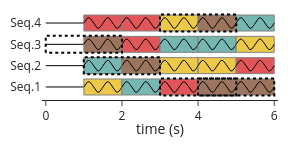

In [5]:
panelname = 'sequences'


sequences = np.asarray([[0,1,3,2,4,4],
                        [0,3,4,1,1,2],
                        [0,4,2,3,3,1],
                        [0,2,2,1,4,3]])
eg_probe = 4

colors = FOURCOLOR

xbox = np.asarray([0,1,1,0,0])
ybox = (np.asarray([0,0,1,1,0])-0.5) * 0.75

egbox_height = 0.8


fig = go.Figure()

for ss, seq in enumerate(sequences):
    for ww, wave_idx in enumerate(seq):
        color = colors[wave_idx]
        if ww > 0:
            # Colored boxes except silence
            _ = fig.add_trace(go.Scatter(x=xbox+ww, y=ybox+ss, fill='toself',
                                         mode='lines',
                                         line=dict(width=1,
                                                   color='gray'),
                                         fillcolor=color,
                                         showlegend=False)
                              )

        # wave form plots
        x = np.linspace(0,1,n_samps) + ww
        y = waves[wave_idx] + ss
        _ = fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                     line=dict(color='black',
                                               width=1),
                                     showlegend=False,
                                     )
                          )

# Add e.g. dotted boxes, ensure are the last to be drawn so they are on top
for ss, seq in enumerate(sequences):
    for ww, wave_idx in enumerate(seq):
        if wave_idx == eg_probe:
            x0 = ww - 1
            y0 = ss - egbox_height/2
            xd, yd = 2, egbox_height  # 2 seconds widht, 2*norm wave
            x = [x0, x0, x0+xd, x0+xd, x0]
            y = [y0, y0+yd, y0+yd, y0, y0]
            _ =  fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                          line=dict(color='black',
                                                    width=2,
                                                    dash='dot'),
                                          showlegend=False,
                                          )
                               )

if panelname in panels:
    panels.pop(panelname)
panels[panelname].extend(fig['data'])

# test show
_ = fig.update_xaxes(title_text='time (s)', title_standoff=0, range=[-0.1,6.1])
_ = fig.update_yaxes(tickmode='array',
                     tickvals=list(range(4)),
                     ticktext=[f'Seq.{i+1}' for i in range(4)],
                     ticks='',
                     showline=False)
fig.update_layout(width=96*3, height=96*1.5,
                  margin={'l':10,'r':10,'t':10,'b':10,},
                  template='simple_white')
# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)


### selected stimuli examples and transition type clasification

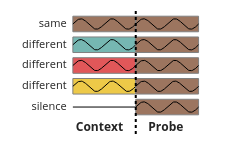

In [6]:
panelname = 'transitions'

fig = go.Figure()
xbox = np.asarray([0, 1, 1, 0, 0])
ybox = (np.asarray([0, 0, 1, 1, 0]) - 0.5) * 0.75

for ww, (wave, color) in enumerate(zip(waves, colors)):
    # context box
    if ww > 0: # omits silence box,
        _ = fig.add_trace(go.Scatter(x=xbox - 1, y=ybox + ww, fill='toself',
                                     mode='lines',
                                     line=dict(width=1,
                                               color='gray'),
                                     fillcolor=color,
                                     showlegend=False)
                          )
    # contex wave
    x = np.linspace(-1, 0, n_samps)  # sum to offset to center, insline with sequences
    y = wave + ww
    _ = fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                 line=dict(color='black',
                                           width=1, ),
                                 showlegend=False)
                      )

    # probe box
    _ = fig.add_trace(go.Scatter(x=xbox, y=ybox + ww, fill='toself',
                                 mode='lines',
                                 line=dict(width=1,
                                           color='gray'),
                                 fillcolor=colors[eg_probe],
                                 showlegend=False)
                      )
    # probe wave
    x = np.linspace(0, 1, n_samps)
    y = waves[eg_probe] + ww
    _ = fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                 line=dict(color='black',
                                           width=1, ),
                                 showlegend=False)
                      )
    # ax.plot(x, y, colors[prb_idx])

    # context type text
    if ww == 0:
        type_text = 'silence'
    elif ww == eg_probe:
        type_text = 'same'
    else:
        type_text = 'different'

    _ = fig.add_trace(go.Scatter(x=[-1.1], y=[ww],
                                 mode='text', text=[type_text],
                                 textposition='middle left', textfont_size=11,
                                 showlegend=False)
                      )

_ = fig.add_vline(x=0, line_width=2, line_color='black', line_dash='dot', opacity=1,
                  )
# context and probe text
_ = fig.add_trace(go.Scatter(x=[-0.2, 0.2],
                             y=[-1, -1],
                             mode='text', text=['<b>Context</b>', '<b>Probe</b>'],
                             textposition=['middle left', 'middle right'], textfont_size=12,
                             showlegend=False)
                  )

if panelname in panels:
    panels.pop(panelname)
panels[panelname].extend(fig['data'])

# test show
_ = fig.update_layout(width=96 * 2.5, height=96 * 1.5,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      xaxis=dict(range=[-2,1.5], visible=False),
                      yaxis=dict(visible=False))
# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# example rasters and PSTHs
## example 2
example 1 comes after.

In [7]:
# Example 2, same as the one used to define the examples
probe = 3
ctx_pair = [0,1]
cellid = 'ARM021b-36-8'

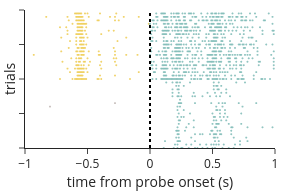

In [8]:
panelname = 'raster'
def formated_raster(cellid, ctx_pair, probe, panelname):
    fig = plot_raw_pair(cellid, ctx_pair, probe, type='raster', raster_fs=100)
    fig.update_traces(line=dict(width=1),
                      marker=dict(size=2,
                                  opacity=0.8,
                                  line=dict(width=0,)))

    if panelname in panels:
        panels.pop(panelname)
    panels[panelname].extend(fig['data'])

    # test show
    fig.update_layout(width=96*3, height=96*2,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      showlegend=False
                      )
    return fig

fig = formated_raster(cellid, ctx_pair, probe, panelname)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

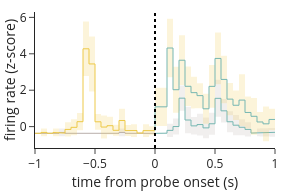

In [9]:
panelname = 'PSTH'
def formated_psth(cellid, ctx_pair, probe, panelname):
    fig = plot_raw_pair(cellid, ctx_pair, probe, raster_fs=20)
    fig.update_traces(line=dict(width=1))

    if panelname in panels:
        panels.pop(panelname)
    panels[panelname].extend(fig['data'])

    # test showe
    fig.update_layout(width=96*3, height=96*2,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      showlegend=False
                      )
    return fig

fig = formated_psth(cellid, ctx_pair, probe, panelname)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Cluster mass signficance and difference quantification

using t-score threshold for sample-alpha 0.05 -> t = 2.024394164575136


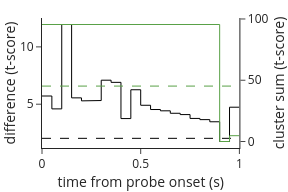

In [10]:
panelname = 'T-score'
panelname2 = 'clusters'

def formated_signif(cellid, ctx_pair, probe, panelname, panelname2):
    fig, main_traces, secondary_traces = plot_time_ser_quant(
        cellid, ctx_pair, probe, multiple_comparisons_axis=[1, 2], cluster_threshold=0.05,
        meta={'raster_fs':20}, secondary_y=True, deltaFR=False, ignore_quant=True)

    for trace in main_traces + secondary_traces:
        trace.update(line_width=1, marker_size=7)
    fig.update_traces(line_width=1, marker_size=7)

    if panelname in panels:
        panels.pop(panelname)
    panels[panelname].extend(main_traces)

    if panelname2 in panels:
        panels.pop(panelname2)
    panels[panelname2].extend(secondary_traces)

    # test show
    fig.update_layout(width=96*3, height=96*2,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      showlegend=False)
    return fig

fig = formated_signif(cellid, ctx_pair, probe, panelname, panelname2)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

integral: 1508.32 t-score*ms
center of mass: 352.31 ms
last bin: 900.00 ms


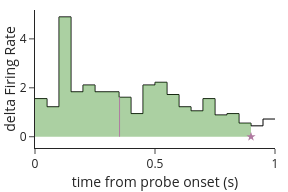

In [11]:
panelname = 'Z-score'
def formated_quant(cellid, ctx_pair, probe, panelname):
    fig= plot_simple_quant(
        cellid, ctx_pair, probe, multiple_comparisons_axis=[1, 2], cluster_threshold=0.05,
        meta={'raster_fs':20},)

    fig.update_traces(line_width=1, marker_size=7)

    if panelname in panels:
        panels.pop(panelname)
    panels[panelname].extend(fig['data'])

    # test show
    fig.update_layout(width=96*3, height=96*2,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      showlegend=False)
    return fig

fig = formated_quant(cellid, ctx_pair, probe, panelname)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## merge individual plotting functions into a line

using t-score threshold for sample-alpha 0.05 -> t = 2.024394164575136
integral: 559.36 t-score*ms
center of mass: 150.75 ms
last bin: 450.00 ms
using t-score threshold for sample-alpha 0.05 -> t = 2.024394164575136
integral: 1508.32 t-score*ms
center of mass: 352.31 ms
last bin: 900.00 ms


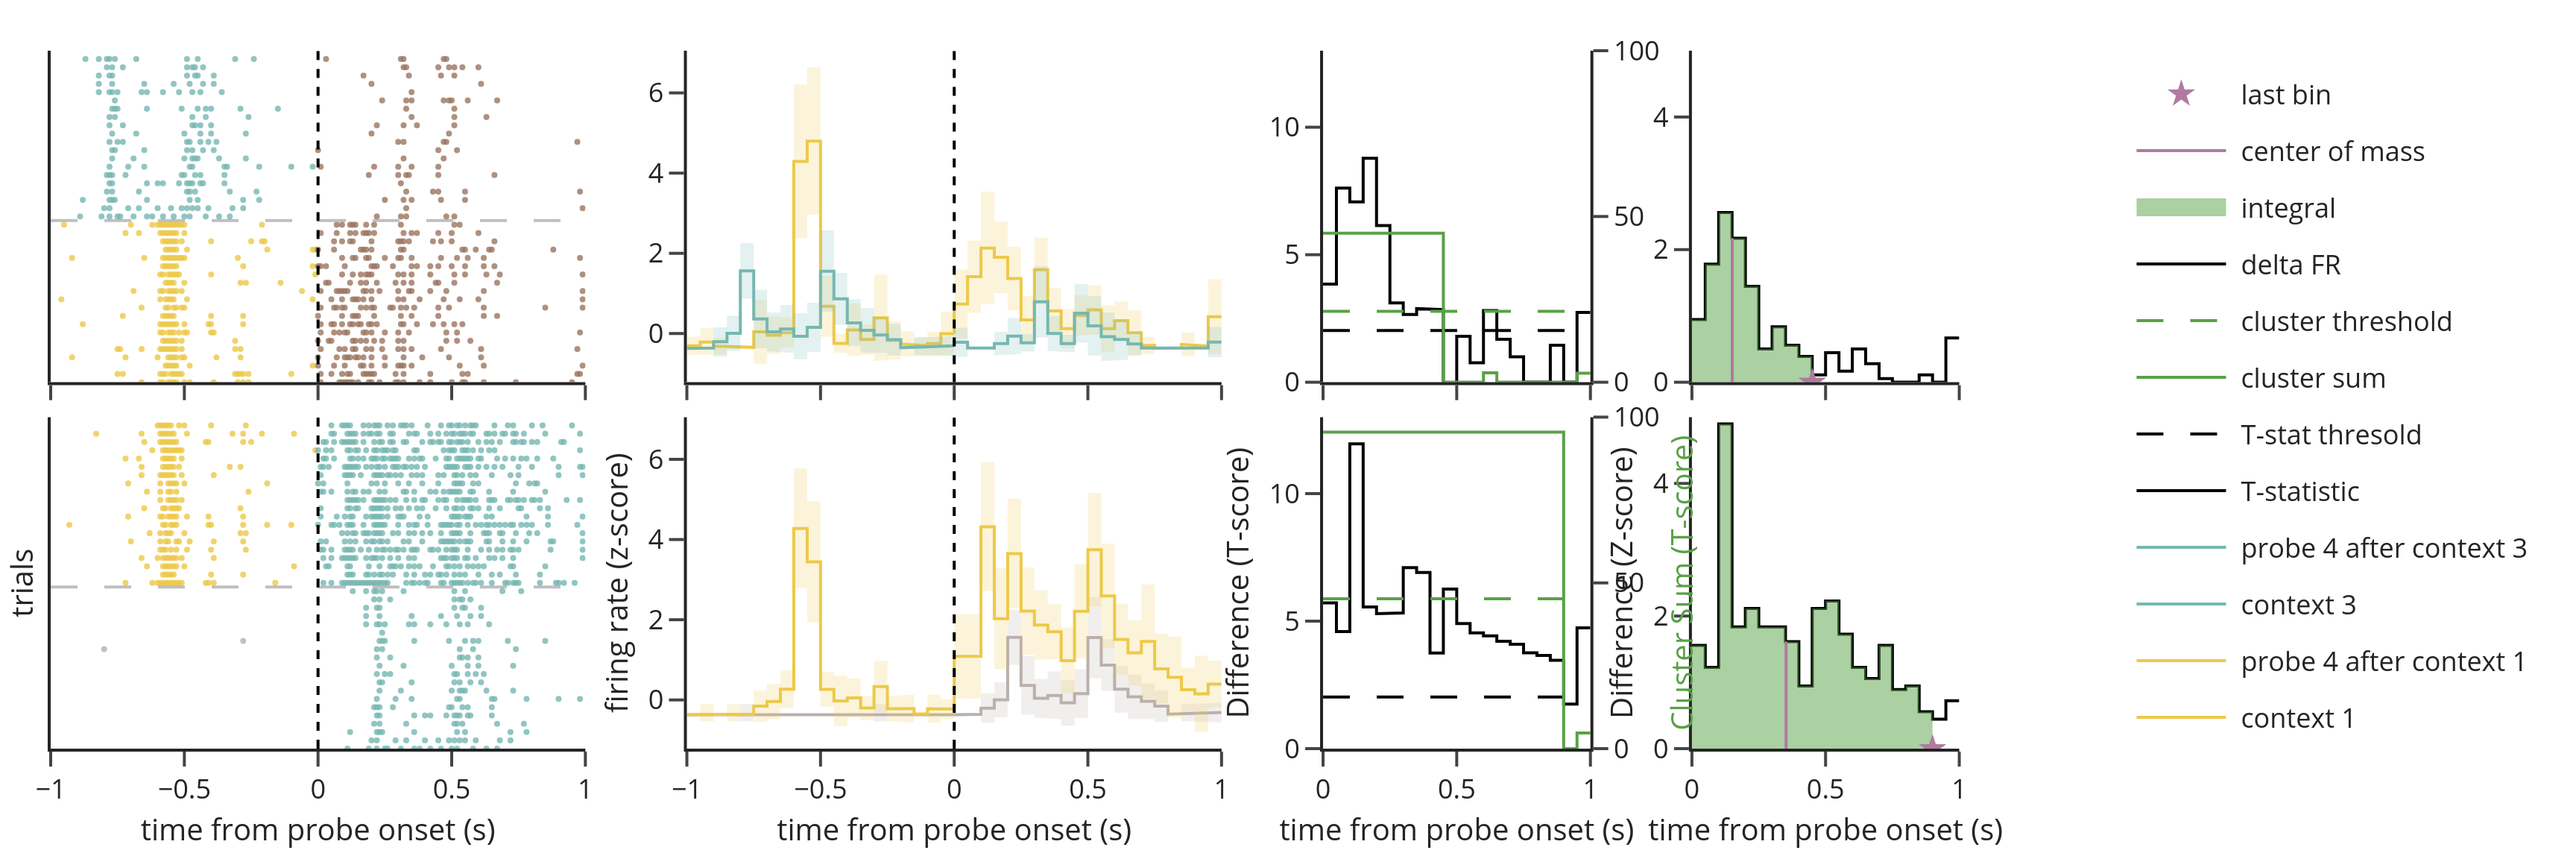

In [12]:
extra_eg = ('ARM021b-43-8', [2,3], 1) # same site, small effect, no super compelling
examples = [
    ('ARM021b-36-8', [1, 3], 4),
    ('ARM021b-36-8', [0, 1], 3),
]
fig = make_subplots(2, 4, shared_xaxes='columns', shared_yaxes='columns', column_widths=[2 / 6, 2 / 6, 1 / 6, 1 / 6],
                    horizontal_spacing=0.05, vertical_spacing=0.05,
                    specs=[[{}, {}, {"secondary_y": True}, {}],
                           [{}, {}, {"secondary_y": True}, {}]])
for ee, (cellid, ctx_pair, probe) in enumerate(examples):
    # raster
    f = plot_raw_pair(cellid, ctx_pair, probe, type='raster', raster_fs=100)
    f.update_traces(line=dict(width=1),
                    showlegend=False,
                    marker=dict(size=2,
                                opacity=0.8,
                                line=dict(width=0, )))

    t = f['data']
    fig.add_traces(t, rows=[ee + 1] * len(t), cols=[1] * len(t))

    # PSTH
    f = plot_raw_pair(cellid, ctx_pair, probe, raster_fs=20, simplify=True)
    f.update_traces(line=dict(width=1))
    if ee !=0:
        f.update_traces(showlegend=False)

    t = f['data']
    fig.add_traces(t, rows=[ee + 1] * len(t), cols=[2] * len(t))

    # significance
    f, main_traces, secondary_traces = plot_time_ser_quant(
        cellid, ctx_pair, probe, multiple_comparisons_axis=[1, 2], cluster_threshold=0.05,
        meta={'raster_fs': 20}, secondary_y=True, deltaFR=False, ignore_quant=True)
    for trace in main_traces + secondary_traces:
        trace.update(line_width=1, marker_size=7)
        if ee !=0:
            trace.update(showlegend=False)


    t = main_traces
    fig.add_traces(t, rows=[ee + 1] * len(t), cols=[3] * len(t))

    t = secondary_traces
    fig.add_traces(t, rows=[ee + 1] * len(t), cols=[3] * len(t), secondary_ys=[True] * len(t))

    # quantification
    f = plot_simple_quant(
        cellid, ctx_pair, probe, multiple_comparisons_axis=[1, 2], cluster_threshold=0.05,
        meta={'raster_fs': 20}, )
    f.update_traces(line_width=1, marker_size=7)
    if ee !=0:
        f.update_traces(showlegend=False)

    t = f['data']
    fig.add_traces(t, rows=[ee + 1] * len(t), cols=[4] * len(t))

w, h = 9, 3  # in inches
_ = fig.update_layout(template='simple_white',
                      margin=dict(l=10, r=10, t=10, b=10),
                      width=round(96*w), height=round(96*h),

                      # top raster
                      yaxis=dict(showticklabels=False, ticks=''),

                      # bottom raster
                      xaxis5=dict(title_text='time from probe onset (s)'),
                      yaxis6=dict(showticklabels=False, ticks='', title_text='trials'),

                      # bottom PSTH
                      xaxis6=dict(title_text='time from probe onset (s)'),
                      yaxis7=dict(title_text='firing rate (z-score)'),


                      # top significance
                      yaxis4=dict(matches='y9'),

                      # bottom significance
                      xaxis7=dict(title_text='time from probe onset (s)'),
                      yaxis8=dict(title_text='Difference (T-score)'),
                      yaxis9=dict(title=dict(text='Cluster Sum (T-score)',font_color=AMPCOLOR)),

                      # bottom quantification
                      xaxis8=dict(title_text='time from probe onset (s)'),
                      yaxis10=dict(title_text='Difference (Z-score)'),

                      legend_font_size=9
                      )

_ = fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9,)
_ = fig.update_yaxes(title=dict(font_size=10, standoff=0), tickfont_size=9,)

# ranges  for rasterss
for rr, cc in itt.product([1,2], [1]):
    _ = fig.update_xaxes(range=[-1,1], row=rr, col=cc)
    _ = fig.update_yaxes(range=[0,40], row=rr, col=cc)

# ranges  for psths
for rr, cc in itt.product([1,2], [2]):
    _ = fig.update_xaxes(range=[-1,1], row=rr, col=cc)
    _ = fig.update_yaxes(autorange=True, row=rr, col=cc)

# ranges for significance
for rr, cc in itt.product([1,2], [3]):
    _ = fig.update_xaxes(range=[0,1], row=rr, col=cc)
    _ = fig.update_yaxes(range=[0,13], row=rr, col=cc, secondary_y=False)
    _ = fig.update_yaxes(range=[0,100], row=rr, col=cc, secondary_y=True)

# ranges for quantification
for rr, cc in itt.product([1,2], [4]):
    _ = fig.update_xaxes(range=[0,1], row=rr, col=cc)
    _ = fig.update_yaxes(range=[0,5], row=rr, col=cc)

# add vertical dashed lines at necesary probe onsets (x=0)
panxy = [(1,1), (1,2), (2,1), (2,2)]
for rr, cc in panxy:
    _ = fig.add_vline(x=0, line_width=1, line_color='black', line_dash='dot', opacity=1,
                      row=rr, col=cc)

# horizontal lines dividing different context trials in rates
panxy = [(1,1),(2,1)]
for rr, cc in panxy:
    trialn = 20
    _ = fig.add_hline(y=trialn-0.5, line_width=1, line_color='gray', line_dash='dash', opacity=0.5,
                      row=rr, col=cc)


filename = folder / 'fig1_examples_quant'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", height=round(96*h), width=round(96*w), scale=4)
Image(img_bytes)

In [13]:
fig.print_grid()

This is the format of your plot grid:
[ (1,1) x,y      ]  [ (1,2) x2,y2    ]  [ (1,3) x3,y3,y4 ]  [ (1,4) x4,y5    ]
[ (2,1) x5,y6    ]  [ (2,2) x6,y7    ]  [ (2,3) x7,y8,y9 ]  [ (2,4) x8,y10   ]

